## Camemebert finetuning Model with Pytorch

In [10]:
import pandas as pd
import torch
import torch.nn as nn
import utilsNb as utils
from transformers import AutoConfig, AutoModel, AutoTokenizer
from transformers.modeling_outputs import TokenClassifierOutput

# reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
class ModelTorch1(nn.Module):
  def __init__(self,checkpoint,num_labels): 
    super(ModelTorch1,self).__init__() 
    self.num_labels = num_labels 

    #Load Model with given checkpoint and extract its body
    self.model = model = AutoModel.from_pretrained(checkpoint,config=AutoConfig.from_pretrained(checkpoint, output_attentions=True,output_hidden_states=True))
    self.dropout = nn.Dropout(0.1) 
    self.classifier = nn.Linear(768,num_labels) # load and initialize weights

  def forward(self, input_ids=None, attention_mask=None,labels=None):
    #Extract outputs from the body
    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

    #Add custom layers
    sequence_output = self.dropout(outputs[0]) #outputs[0]=last hidden state

    logits = self.classifier(sequence_output[:,0,:].view(-1,768)) # calculate losses
    
    loss = None
    if labels is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
    
    return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions)

In [12]:
ID_TO_LABEL = {
    0: 'non-esg',
    1: 'environnemental',
    2: 'social',
    3: 'gouvernance'
}

DATASET_PATH = '../data/final_test_esg.csv'

CHECKPOINT = 'camembert-base'
NUM_LABELS = len(ID_TO_LABEL)
LABEL_TO_ID = {v: k for k, v in ID_TO_LABEL.items()}
TOKENIZER = AutoTokenizer.from_pretrained('camembert-base')
model_path ='../models/torch_models/state_dicts/torchmodel1.pt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [13]:
model = torch.load("../models/torch_models/state_dicts/torchmodel1.pt", map_location=torch.device('cpu'))
model = ModelTorch1(checkpoint=CHECKPOINT, num_labels=NUM_LABELS)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()
print('\n Model loaded for evaluation')

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



 Model loaded for evaluation


In [14]:
df = pd.read_csv(DATASET_PATH)

In [15]:
df_res = utils.predict_df(model, TOKENIZER, df, device)

In [16]:
df_res.to_csv('../data/torch_model_predictions.csv')

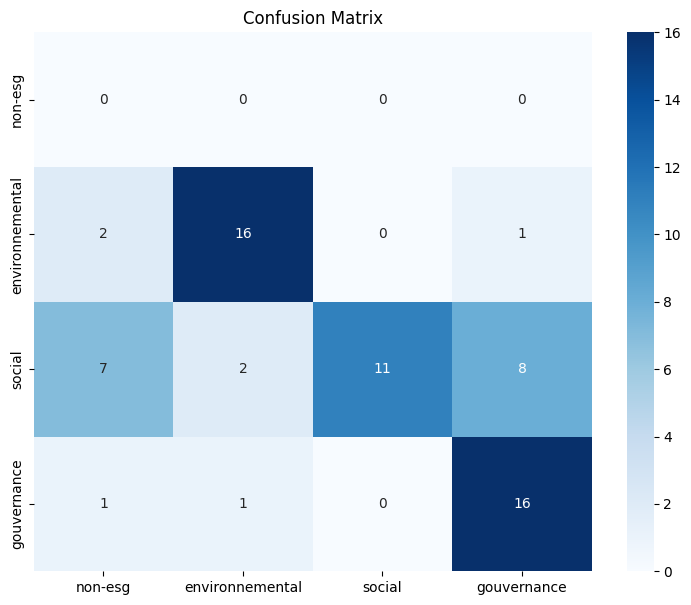

In [17]:
utils.plot_confusion_matrix(df_res['esg_category'], df_res['predicted_class'], list(ID_TO_LABEL.values()))